In [4]:
import numpy as np

#dataset_name = 'data_set' + letter + '.dat'"
data = np.loadtxt( 'data_setA.dat' )

In [5]:
# i be the row index which increased from bottom to top of each character.
# j be the column index which increased from left to right of the character.

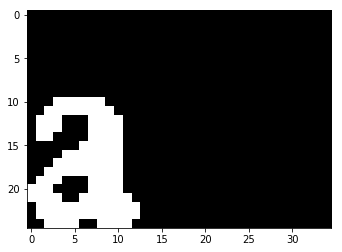

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
pattern = data[0:25]
pattern = np.flipud(pattern)
# Matplotlib imshow to mapping the 0 and 1 into black and white pattern in the image, respectively.
plt.imshow(pattern, cmap='gray', interpolation='nearest')


In [7]:
def index_title(printing=False):
    characters = ['a', 'c', 'e', 'm', 'n', 'o', 'r', 's', 'x', 'z']
    indexes = []
    for char in characters:
        for i in range(1, 10+1):
            index = char + str(i)
            indexes.append(index)
        if printing==True:
            indexes.append('mean(' + char +')')
            indexes.append('var(' + char + ')')

    #print(indexes)
    row_names = np.array(indexes)
    row_names = pd.DataFrame(row_names)
    return characters, list(row_names[0])

In [8]:
import math
import numpy as np
import pandas as pd


I = [i for i in range(1,25+1)] # An array containing indexes in one of column
J = [i for i in range(1,35+1)] # An array containing indexes in one of row
#print(col, row)

def centroid(init, last, data):
    pattern = data[init:last]
    pattern = np.flipud(pattern)
    sum_sum_Xij = np.sum(pattern)
    sum_sum_Xij_times_i = sum(np.dot(pattern.T, I))
    sum_sum_Xij_times_j = sum(np.dot(pattern, J))
    
    imean = sum_sum_Xij_times_i/sum_sum_Xij
    jmean = sum_sum_Xij_times_j/sum_sum_Xij
    
    return pattern, imean, jmean

def mpq(pattern, imean, jmean, p, q):
    # The (p,q)th Central Moment of a pattern X is:
    i_part = (I-imean)**p
    i_part = np.reshape(i_part, (25,1))
    
    j_part = (J-jmean)**q
    j_part = np.reshape(j_part, (35, 1))
    
    step = pattern * i_part
    Mpq = np.sum(np.dot(step, j_part))
    #Mpq = step * j_part
    return float(Mpq)
'''
def mpq(pattern, imean, jmean, p, q):
    # The (p,q)th Central Moment of a pattern X is:
    total = 0
    for i in range(len(I)):
        for j in range(len(J)):
            total += (I[i] - imean)**p * (J[j] - jmean)**q * pattern[i][j]
    
    return total
'''

p = [0,0,1,2,0,1,2,3]
q = [0,2,1,0,3,2,1,0]

# Root mean square function.
def rms(df):
    df = np.array(df) **2
    rms = np.sqrt(np.mean(df))
    return rms

def all_rms(p, q, data):
    moments = [] # Moments of 100 samples
    overall_rms = []
    M = []
    mean = []
    var = []
    
    for index_p, index_q in zip(p,q):
        column_names = "M" + str(index_p) + str(index_q)
        M.append(column_names)
        
        central_moments = []

        init = 0
        last = 25
        counter = 0
    
        while last <= len(data):
            
            pattern, imean, jmean = centroid(init,last, data)
            Mpq = mpq(pattern, imean, jmean, index_p, index_q)
            central_moments.append(Mpq)
    
            # Put mean and var of the normalized central moments here
            
            # Direct answer for the variance in the set of means.
            #np.var already divides by N rather than N-1
            
            # Break point. It's time to stop.
            init += 25
            last += 25
            
        # 100 central_moments will be divided into 10
        
        RMS = rms(central_moments)
        moments.append(central_moments/RMS)
        
        overall_rms.append(RMS)
       
        # Clearing
        central_moments = []
        
    return M, pd.DataFrame(moments), overall_rms

In [9]:
def mean_and_var(Mpq, central_moments):
    k = 0
    l = 10
    all_means = []
    all_var = []
    central_moments.columns = Mpq
    while l <= 100:
        target = central_moments[k:l]
        means = []
        var = []
        for i in Mpq:
            element_mean = np.mean(target[i])
            # Direct answer for the variance in the set of means.
            element_var = np.var(target[i]) #np.var already divides by N rather than N-1
            means.append(element_mean)
            var.append(element_var)
        all_means.append(means)
        all_var.append(var)
        means = []
        var = []
        k += 10
        l += 10

    #print("mean", all_means)
    #print("var", all_var)

    mean_df = np.array(all_means)
    mean_df = pd.DataFrame(mean_df)

    var_df = np.array(all_var)
    var_df = pd.DataFrame(var_df)
    
    return mean_df, var_df

In [10]:
def indexing_nms(data):
    Mpq, moments, overall_rms = all_rms(p,q,data)
    normalized_cm = moments.transpose()

    mean_df, var_df = mean_and_var(Mpq, normalized_cm)
    mean_df.columns = Mpq
    var_df.columns = Mpq
    characters, indexes = index_title()

    title_add = []
    for i in range(len(mean_df)):
        normalized_cm = pd.concat([normalized_cm, mean_df.loc[[i]]])
        normalized_cm = pd.concat([normalized_cm, var_df.loc[[i]]])
        title_add.append('mean('+ characters[i]+')')
        title_add.append('var('+ characters[i]+')')

    overall_rms = pd.DataFrame(overall_rms).T
    overall_rms.columns = Mpq
    normalized_cm = pd.concat([normalized_cm, overall_rms.loc[[0]]])

    new_indexes = indexes + title_add + ['overall_rms']
    
    normalized_cm.index = new_indexes
    print('Indexing finished, generate normalized central moments')
    return normalized_cm, mean_df, var_df, overall_rms


In [11]:
def cov(X0):
    X = X0 - X0.mean(axis=0)
    N = X.shape[0]                # !!!# Divide by N
    covariance = np.dot(X.T, X)/N
    return covariance # !!!

In [12]:
def ncm_to_report(csv_file, normalized_data, mean_df, var_df, overall_rms):
    mean_df = mean_df
    var_df = var_df
    overall_rms = overall_rms
    letters = ['a', 'c', 'e', 'm', 'n', 'o', 'r', 's', 'x', 'z']
    for i in range(0,10):
        init=i * 10
        last = init+10
        
        ncm = pd.DataFrame(normalized_data[init:last])
        ncm.to_csv(csv_file, mode='a', float_format='%.3f')
        
        mean_target = mean_df.iloc[[i]]
        mean_target.index = ['mean(' + letters[i] + ')']
        mean_target.to_csv(csv_file, mode='a', header=None, float_format='%.3f')
        
        var_target = var_df.iloc[[i]]
        var_target.index = ['var(' + letters[i] + ')']
        var_target.to_csv(csv_file, mode='a', header=None, float_format='%.3f')
    
    overall_rms.index = ['Overall RMS']
    overall_rms.to_csv(csv_file, mode='a')
    
    line_break = pd.DataFrame([" "])
    line_break.to_csv(csv_file, mode='a', header=None, index=None)
    
    print("Ncm is written to %s" %csv_file)

In [13]:
def cov_inv_to_report(csv_file, normalized_data, dataset_name):
    from numpy.linalg import inv
    letters = ['a', 'c', 'e', 'm', 'n', 'o', 'r', 's', 'x', 'z']
    line_break = pd.DataFrame([" "])
    # To name the index as Inverse-Cov-Dataset-nth or Cov-Dataset-nth
    def index_title(mode, dataset_name, letter):
        title = ''
        if mode == "inverse":
            title = 'Inverse-Cov-Dataset-' + dataset_name + '-'+ letter
        else:
            title = 'Cov-Dataset-' + dataset_name + '-' + letter
        the_title = [title] + [' ' for i in range(7)]
        return the_title
    
    saved_cov = np.zeros(8) 
    container_cov = []
    # Running through for the Covariance
    for i in range(0,10):
        init=i * 10
        last = init+10
        cov_letter = cov(normalized_data[init:last])
        saved_cov = np.add(saved_cov,cov_letter)
        cov_a = pd.DataFrame(cov_letter)
        container_cov.append(cov_a)
        cov_a.index = index_title("cov", dataset_name, letters[i])
        cov_a.to_csv(csv_file, mode='a', header=None, float_format='%.5f')
   
        line_break.to_csv(csv_file, mode='a', header=None, index=None)
    
    container_inv = []
    # Running through for the Inverse of the Covariance
    for i in range(0,10):
        init=i * 10
        last = init+10
        inv_letter = inv(cov(normalized_data[init:last]))
        inv_a = pd.DataFrame(inv_letter)
        container_inv.append(inv_a)
        inv_a.index = index_title("inverse", dataset_name, letters[i])
        inv_a.to_csv(csv_file, mode='a', header=None, float_format='%.5f')
        line_break.to_csv(csv_file, mode='a', header=None, index=None)
    
    average_cov = saved_cov/10
    average_cov_inversed = inv(average_cov)
    
    average_cov = pd.DataFrame(average_cov)
    average_cov.index = ['Cov-Dataset-'+dataset_name] + [' ' for i in range(7)]
    average_cov.to_csv(csv_file, mode='a', header=None, float_format='%.6f')
    
    line_break.to_csv(csv_file, mode='a', header=None, index=None)
    
    average_cov_inversed = pd.DataFrame(average_cov_inversed)
    average_cov_inversed.index = ['Inverse-Cov-Dataset-'+dataset_name] + [' ' for i in range(7)]
    average_cov_inversed.to_csv(csv_file, mode='a', header=None, float_format='%.6f')
    
    #print('Covariance and its Inverse are written to %s!' % csv_file)
    return average_cov, average_cov_inversed, container_cov, container_inv
        

In [14]:
def all_reports(adding_suffix):
    list_datasets = ['A', 'B', 'C', 'D']

    for i in range(len(list_datasets)):
        letter = list_datasets[i]
        label = 'data_set' + letter
        dataset = label +'.dat'
        data = np.loadtxt(dataset)
        normalized_cm, mean_df, var_df, overall_rms = indexing_nms(data)

        label = label + adding_suffix
        ncm_to_report(label, normalized_cm, mean_df, var_df, overall_rms)

        cov_inv_to_report(label, normalized_cm, letter)  

In [15]:
#print(all_reports('_revised_report.csv'))

# Project 2

This project contains six different trainable classifiers.

In [16]:
# all the means
list_datasets = ['A', 'B', 'C', 'D']
letter = list_datasets[0]
label = 'data_set' + letter
dataset = label +'.dat'
datasetA = np.loadtxt(dataset)
normalized_cm_A, mean_df_A, var_df_A, overall_rms_A = indexing_nms(datasetA)
print(overall_rms_A)
overall_rms_A = np.array(overall_rms_A)[0]

def modified_all_rms(p, q, data, overall_rms_A):
    moments = [] # Moments of 100 samples
    overall_rms = overall_rms_A
    M = []
    mean = []
    var = []
    counter = 0
    for index_p, index_q in zip(p,q):
        column_names = "M" + str(index_p) + str(index_q)
        M.append(column_names)
        
        central_moments = []

        init = 0
        last = 25
        
    
        while last <= len(data):
            
            pattern, imean, jmean = centroid(init,last, data)
            Mpq = mpq(pattern, imean, jmean, index_p, index_q)
            central_moments.append(Mpq)
    
            # Put mean and var of the normalized central moments here
            
            # Direct answer for the variance in the set of means.
            #np.var already divides by N rather than N-1
            
            # Break point. It's time to stop.
            init += 25
            last += 25
            
        # 100 central_moments will be divided into 10
        RMS = rms(central_moments)
        
        moments.append(central_moments/overall_rms_A[counter])
        counter += 1
       
        # Clearing
        central_moments = []
        
    return M, pd.DataFrame(moments), overall_rms

def modified_indexing_nms(data,overall_rms_A):
    Mpq, moments, overall_rms = modified_all_rms(p,q,data,overall_rms_A)
    normalized_cm = moments.transpose()

    mean_df, var_df = mean_and_var(Mpq, normalized_cm)
    mean_df.columns = Mpq
    var_df.columns = Mpq
    characters, indexes = index_title()

    title_add = []
    for i in range(len(mean_df)):
        normalized_cm = pd.concat([normalized_cm, mean_df.loc[[i]]])
        normalized_cm = pd.concat([normalized_cm, var_df.loc[[i]]])
        title_add.append('mean('+ characters[i]+')')
        title_add.append('var('+ characters[i]+')')

    overall_rms = pd.DataFrame(overall_rms).T
    overall_rms.columns = Mpq
    normalized_cm = pd.concat([normalized_cm, overall_rms.loc[[0]]])

    new_indexes = indexes + title_add + ['overall_rms']
    
    normalized_cm.index = new_indexes
    print('Indexing finished, generate normalized central moments')
    return normalized_cm, mean_df, var_df, overall_rms



def taken(list_datasets):
    for i in range(len(list_datasets)):
        letter = list_datasets[i]
        label = 'data_set' + letter
        dataset = label +'.dat'
        data = np.loadtxt(dataset)
        normalized_cm, mean_df, var_df, overall_rms = modified_indexing_nms(data,overall_rms_A)
        #print(mean_df)
        #print(normalized_cm[0:100]) # No 0 to 100 to keep all the moments.
    return mean_df, normalized_cm[0:100] # Result are mean_df, normalized_cm until the 100th line only

mean_df_A, normalized_cm_A = taken(list_datasets[0])
mean_df_B, normalized_cm_B = taken(list_datasets[1])
mean_df_C, normalized_cm_C = taken(list_datasets[2])
mean_df_D, normalized_cm_D = taken(list_datasets[3])

Indexing finished, generate normalized central moments
          M00          M02         M11          M20          M03          M12  \
0  131.088215  3797.278877  231.822154  2975.122165  1042.556578  2293.318746   

          M21          M30  
0  930.215497  2147.195582  
Indexing finished, generate normalized central moments
Indexing finished, generate normalized central moments
Indexing finished, generate normalized central moments
Indexing finished, generate normalized central moments


In [17]:
#np.reshape(mean_df.iloc[0], (1,8))
mu = np.array(mean_df_A[0:1])
x = np.array(normalized_cm_A[0:1])
print(mu)
print(x)

[[ 1.00161559  0.3571374   0.24560798  0.86172906 -0.64366066  0.5697219
  -0.25145362 -1.17986173]]
[[ 0.90778565  0.30668578  0.36234673  0.76457562 -0.6987141   0.44748917
  -0.33112414 -1.13956964]]


In [18]:
def euclid_dist(x, mean):
    distance = np.dot((x - mean), (x-mean).T)
    return distance

In [19]:
euclid_dist(x, mu) # Testing for the a1 in compared to the mean a

array([[ 0.06035872]])

In [ ]:
letters = ['a', 'c', 'e', 'm', 'n', 'o', 'r', 's', 'x', 'z']
from numpy.linalg import inv
def discriminant_function(x, mean_df, discriminant, label, letter, normalized_cm):
    count = 0
    minimum_dist = 0
    container = [] # Container contains all the x_i - mu
    average_cov, average_cov_inversed, container_cov, container_inv = cov_inv_to_report(label, normalized_cm, letter) 
    
    for i in range(1,len(mean_df)+1):
        k = i - 1
        mu = np.array(mean_df[count:i])
        mean = mu
        
        
        #1 Minimum distance moment classifier
        if discriminant == 1:
            dist = float(euclid_dist(x, mu))
            container.append(dist)
           
        #2 Bayes moment classifier with identical covariances.
        if discriminant == 2:  
            
             
            g_x_2 = abs(-0.5 * np.dot(np.dot((x - mean), average_cov_inversed), (x-mean).T)) #
            container.append(g_x_2[0][0])
        
        #3 Bayes moment classifier with individual class covariances: quadratic decision function
        if discriminant == 3:
            
            sigma_i = np.array(container_cov[k]) # i-th will follow the mean of each character.
            sigma_i_inv = np.array(container_inv[k])
            
            g_x_3 = abs((-0.5 * np.log(np.linalg.det(sigma_i)) - (0.5 * (np.dot(np.dot(np.subtract(x, mean), sigma_i_inv), np.subtract(x,mean).T)) )))
            container.append(g_x_3[0][0])
            
        #4 Bayes moment classifier using the first four moments
        if discriminant == 4:
            
            x_1by4 = x[0][0:4]
            mean_1by4 = mean[0][0:4]
            
            sigma_i = np.array(container_cov[k])
            sigma_i_4by4 = sigma_i[0:4, 0:4]
            sigma_i_inv_4by4 = inv(sigma_i_4by4)

            g_x_4 = abs((-0.5 *  np.log(np.linalg.det(sigma_i_4by4))- (0.5 * (np.dot(np.dot((x_1by4 - mean_1by4), sigma_i_inv_4by4), (x_1by4-mean_1by4).T)) )) )
            container.append(g_x_4)
        count += 1
    #saved = pd.DataFrame(np.dot(container, 100))
    return container, saved
  
def figuring_letter(letters, container):
    y = list(zip(letters, container))
    for i in y:
        if min(container) in i:
            return i[0], i[1]

def prediction(normalized_cm, mean_df, discriminant, label, letter, namefile):
    count = 0
    comparison = []

    for i in range(1,len(normalized_cm)+1):
        x = np.array(normalized_cm[count:i])
        count += 1
        
        container, saved = discriminant_function(x, mean_df, discriminant, label, letter, normalized_cm)
        char, score = figuring_letter(letters, container)
        comparison.append(char)
        #saved.T.to_csv(namefile, mode='a', float_format='%.f', index=None, header=None)

    return comparison

In [21]:
from collections import Counter

list_datasets = ['A', 'B', 'C','D']
for letter in list_datasets:
    normalized_label = "normalized_cm_" + letter
    mean_label = "mean_df_" + letter
    label = 'data_set' + letter
    discriminant = 1
    pred = prediction(eval(normalized_label), eval(mean_label), discriminant, label, letter, '1_'+letter+'.csv')# eval(mean_label)
    
    print("Prediction using minimum distance moment classifier in Dataset", letter)
    print(pred)
    print(sorted(Counter(pred).items())) # We do count the number of the elements then sort it by the items.


Prediction using minimum distance moment classifier in Dataset A
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 's', 'o', 'o', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z']
[('a', 10), ('c', 10), ('e', 10), ('m', 10), ('n', 10), ('o', 9), ('r', 10), ('s', 11), ('x', 10), ('z', 10)]
Prediction using minimum distance moment classifier in Dataset B
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'o', 'o'

In [23]:
from collections import Counter

list_datasets = ['A', 'B', 'C','D']
for letter in list_datasets:
    normalized_label = "normalized_cm_" + letter
    mean_label = "mean_df_" + letter
    label = 'data_set' + letter
    discriminant = 2
    pred = prediction(eval(normalized_label), eval(mean_label), discriminant, label, letter, '2_'+letter+'.csv')
    print("Prediction using Bayes moment classifier with identical covariances in Dataset", letter)
    print(pred)
    print(sorted(Counter(pred).items())) # We do count the number of the elements then sort it by the items.


Prediction using Bayes moment classifier with identical covariances in Dataset A
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z']
[('a', 10), ('c', 10), ('e', 10), ('m', 10), ('n', 10), ('o', 10), ('r', 10), ('s', 10), ('x', 10), ('z', 10)]
Prediction using Bayes moment classifier with identical covariances in Dataset B
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'n', 'n', 'n', 'n', 'n', 

In [24]:
from collections import Counter

list_datasets = ['A', 'B', 'C','D']
for letter in list_datasets:
    normalized_label = "normalized_cm_" + letter
    mean_label = "mean_df_" + letter
    label = 'data_set' + letter
    discriminant = 3
    pred = prediction(eval(normalized_label), eval(mean_label), discriminant, label, letter, '3_'+letter+'.csv')
    print("Prediction using Bayes moment classifier with individual class covariances in Dataset", letter)
    print(pred)
    print(sorted(Counter(pred).items())) # We do count the number of the elements then sort it by the items.


Prediction using Bayes moment classifier with individual class covariances in Dataset A
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z']
[('a', 10), ('c', 10), ('e', 10), ('m', 10), ('n', 10), ('o', 10), ('r', 10), ('s', 10), ('x', 10), ('z', 10)]
Prediction using Bayes moment classifier with individual class covariances in Dataset B
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'n', 'n', '

In [25]:
from collections import Counter

list_datasets = ['A', 'B', 'C','D']
for letter in list_datasets:
    normalized_label = "normalized_cm_" + letter
    mean_label = "mean_df_" + letter
    label = 'data_set' + letter
    discriminant = 4
    pred = prediction(eval(normalized_label), eval(mean_label), discriminant, label, letter, '4_'+letter+'.csv')
    print("Prediction using Byes moment classifier with individual class covariances only first four moments in Dataset", letter)
    print(pred)
    print(sorted(Counter(pred).items())) # We do count the number of the elements then sort it by the items.


Prediction using Byes moment classifier with individual class covariances only first four moments in Dataset A
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'a', 'a', 'a', 'a', 's', 's', 'a', 's', 'a', 's', 'z', 'x', 'z', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z']
[('a', 16), ('c', 10), ('e', 10), ('m', 10), ('n', 10), ('o', 10), ('r', 10), ('s', 4), ('x', 8), ('z', 12)]
Prediction using Byes moment classifier with individual class covariances only first four moments in Dataset B
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'c', 'c', 'o', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'm', 'm', 'm', 'm

In [26]:
from collections import Counter
letters = ['a', 'c', 'e', 'm', 'n', 'o', 'r', 's', 'x', 'z']

def pred_dist_binary_pixel(data, data_target, init_target, last_target, function):
    init = list(range(0, 2500, 250))
    last = list(range(250, 2750, 250))
    distances = []
    for i, l in list(zip(init, last)):
        a = list(range(i, l,25))
        b = list(range(i+25, l+25, 25))

        summa_pattern = 0
        for n, m in list(zip(a,b)):
            summa_pattern += data[n:m]

        summa_pattern = np.flipud(summa_pattern)

        Pi = (summa_pattern+1)/12 # (m+1)/(n+2) ==> Pi
        #plt.imshow(Pi, cmap='gray', interpolation='nearest')


        x_target= data_target[init_target:last_target]
        x_target= np.flipud(x_target)
        
        if function == 1:
            distance = np.sqrt(np.sum((x_target - Pi)**2))
            distances.append(distance)
        if function == 2:
            g_x_6 = np.sum(abs(x_target * np.log(Pi) + (1-x_target) * np.log(1- Pi)))
            distances.append(g_x_6)
        '''
        for n, m in list(zip(a,b)):
            x_target= data[n:m]
            x_target= np.flipud(x_target)

            #5 Euclidian distance - Minimum distance classifier in binary pixel.
            distance = np.sqrt(np.sum((x_target - Pi)**2))
            distances.append(distance)

        '''
    char, score = figuring_letter(letters, distances)
    saved = pd.DataFrame(np.dot(distances, 100))
    return char, saved

def iter_pred_dist_binary_pixel(data, data_target, function, namefile):
    container=[]
    init = list(range(0, 2500, 25))

    last = list(range(25, 2525, 25))

    for i, l in list(zip(init, last)):
        char, saved = pred_dist_binary_pixel(data, data_target, i, l, function)
        container.append(char)
        #saved.T.to_csv(namefile, mode='a', float_format='%.f', index=None, header=None)
    
    print(container)
    print(sorted(Counter(container).items()))
    

list_datasets = ['A', 'B', 'C','D']
data = np.loadtxt('data_setA.dat')
for i in list_datasets:
    letter = i
    label = 'data_set' + letter
    dataset = label +'.dat'
    data_target = np.loadtxt(dataset)
    print('Prediction using Minimum distance classifier in binary pixel space in dataset', letter)
    iter_pred_dist_binary_pixel(data, data_target, 1, '5_'+letter+'.csv')
    

Prediction using Minimum distance classifier in binary pixel space in dataset A
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z']
[('a', 10), ('c', 10), ('e', 10), ('m', 10), ('n', 10), ('o', 10), ('r', 10), ('s', 10), ('x', 10), ('z', 10)]
Prediction using Minimum distance classifier in binary pixel space in dataset B
['a', 'a', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'n', 'n', 'n', 'n', 'n', 'n

In [27]:
list_datasets = ['A', 'B', 'C','D']
data = np.loadtxt('data_setA.dat')
for i in list_datasets:
    letter = i
    label = 'data_set' + letter
    dataset = label +'.dat'
    data_target = np.loadtxt(dataset)
    print('Prediction using Bayes classifier in binary pixel space in dataset', letter)
    iter_pred_dist_binary_pixel(data, data_target, 2, '6_'+letter+'.csv')

Prediction using Bayes classifier in binary pixel space in dataset A
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z']
[('a', 10), ('c', 10), ('e', 10), ('m', 10), ('n', 10), ('o', 10), ('r', 10), ('s', 10), ('x', 10), ('z', 10)]
Prediction using Bayes classifier in binary pixel space in dataset B
['a', 'a', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n',

In [31]:
expected = ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z']

In [62]:
from sklearn.metrics import confusion_matrix
#Prediction using minimum distance moment classifier in Dataset A
predicted_A = ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 's', 'o', 'o', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z']
results = confusion_matrix(expected, predicted_A)
print(results)
letters = ['a', 'c', 'e', 'm', 'n', 'o', 'r', 's', 'x', 'z']
test = pd.DataFrame(results, index=letters, columns=letters)
test.to_csv('confusion_1_A.csv')
print(test)

[[10  0  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0  0  9  0  1  0  0]
 [ 0  0  0  0  0  0 10  0  0  0]
 [ 0  0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0  0  0 10]]
    a   c   e   m   n  o   r   s   x   z
a  10   0   0   0   0  0   0   0   0   0
c   0  10   0   0   0  0   0   0   0   0
e   0   0  10   0   0  0   0   0   0   0
m   0   0   0  10   0  0   0   0   0   0
n   0   0   0   0  10  0   0   0   0   0
o   0   0   0   0   0  9   0   1   0   0
r   0   0   0   0   0  0  10   0   0   0
s   0   0   0   0   0  0   0  10   0   0
x   0   0   0   0   0  0   0   0  10   0
z   0   0   0   0   0  0   0   0   0  10


In [101]:
#Prediction using minimum distance moment classifier in Dataset B
predicted_B = ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 's', 'o', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'x', 'x', 'z', 'z', 'x', 'x', 'x', 'x', 'x', 'x', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'x', 'z']

results = confusion_matrix(expected, predicted_B)
print(results)
letters = ['a', 'c', 'e', 'm', 'n', 'o', 'r', 's', 'x', 'z']
test = pd.DataFrame(results, index=letters, columns=letters)
test.to_csv('confusion_1_B.csv')
print(test)

[[10  0  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0  0  9  0  1  0  0]
 [ 0  0  0  0  0  0 10  0  0  0]
 [ 0  0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0  0  0  8  2]
 [ 0  0  0  0  0  0  0  0  1  9]]
    a   c   e   m   n  o   r   s  x  z
a  10   0   0   0   0  0   0   0  0  0
c   0  10   0   0   0  0   0   0  0  0
e   0   0  10   0   0  0   0   0  0  0
m   0   0   0  10   0  0   0   0  0  0
n   0   0   0   0  10  0   0   0  0  0
o   0   0   0   0   0  9   0   1  0  0
r   0   0   0   0   0  0  10   0  0  0
s   0   0   0   0   0  0   0  10  0  0
x   0   0   0   0   0  0   0   0  8  2
z   0   0   0   0   0  0   0   0  1  9


In [102]:
#Prediction using minimum distance moment classifier in Dataset C
predicted_C = ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z']
results = confusion_matrix(expected, predicted_C)
print(results)
letters = ['a', 'c', 'e', 'm', 'n', 'o', 'r', 's', 'x', 'z']
test = pd.DataFrame(results, index=letters, columns=letters)
test.to_csv('confusion_1_C.csv')
print(test)

[[10  0  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  0  0 10  0  0  0]
 [ 0  0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0  0  0 10]]
    a   c   e   m   n   o   r   s   x   z
a  10   0   0   0   0   0   0   0   0   0
c   0  10   0   0   0   0   0   0   0   0
e   0   0  10   0   0   0   0   0   0   0
m   0   0   0  10   0   0   0   0   0   0
n   0   0   0   0  10   0   0   0   0   0
o   0   0   0   0   0  10   0   0   0   0
r   0   0   0   0   0   0  10   0   0   0
s   0   0   0   0   0   0   0  10   0   0
x   0   0   0   0   0   0   0   0  10   0
z   0   0   0   0   0   0   0   0   0  10


In [105]:
#Prediction using minimum distance moment classifier in Dataset D
predicted_D = ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 's', 's', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z']
results = confusion_matrix(expected, predicted_D)
print(results)
letters = ['a', 'c', 'e', 'm', 'n', 'o', 'r', 's', 'x', 'z']
test = pd.DataFrame(results, index=letters, columns=letters)
test.to_csv('confusion_1_D.csv')
print(test)

[[10  0  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  0  0 10  0  0  0]
 [ 0  0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0  2  0  8]]
    a   c   e   m   n   o   r   s   x  z
a  10   0   0   0   0   0   0   0   0  0
c   0  10   0   0   0   0   0   0   0  0
e   0   0  10   0   0   0   0   0   0  0
m   0   0   0  10   0   0   0   0   0  0
n   0   0   0   0  10   0   0   0   0  0
o   0   0   0   0   0  10   0   0   0  0
r   0   0   0   0   0   0  10   0   0  0
s   0   0   0   0   0   0   0  10   0  0
x   0   0   0   0   0   0   0   0  10  0
z   0   0   0   0   0   0   0   2   0  8


In [35]:
#Prediction using minimum distance moment classifier in Dataset A
#predicted = ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 's', 'o', 'o', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z']
#[('a', 10), ('c', 10), ('e', 10), ('m', 10), ('n', 10), ('o', 9), ('r', 10), ('s', 11), ('x', 10), ('z', 10)]
#Prediction using minimum distance moment classifier in Dataset B
#predicted = ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 's', 'o', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'x', 'x', 'z', 'z', 'x', 'x', 'x', 'x', 'x', 'x', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'x', 'z']
#[('a', 10), ('c', 10), ('e', 10), ('m', 10), ('n', 10), ('o', 9), ('r', 10), ('s', 11), ('x', 9), ('z', 11)]
#Prediction using minimum distance moment classifier in Dataset C
#predicted =['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z']
#[('a', 10), ('c', 10), ('e', 10), ('m', 10), ('n', 10), ('o', 10), ('r', 10), ('s', 10), ('x', 10), ('z', 10)]
#Prediction using minimum distance moment classifier in Dataset D
predicted =['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'n', 'm', 'm', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'o', 'o', 'o', 's', 'o', 'o', 'o', 'o', 'o', 'o', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'z', 's', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z']
#[('a', 10), ('c', 10), ('e', 10), ('m', 9), ('n', 11), ('o', 9), ('r', 10), ('s', 12), ('x', 10), ('z', 9)]
results = confusion_matrix(expected, predicted)
print(results)
letters = ['a', 'c', 'e', 'm', 'n', 'o', 'r', 's', 'x', 'z']
test = pd.DataFrame(results, index=letters, columns=letters)
print(test)

[[10  0  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0  0  9  1  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0  0  9  0  1  0  0]
 [ 0  0  0  0  0  0 10  0  0  0]
 [ 0  0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0  1  0  9]]
    a   c   e  m   n  o   r   s   x  z
a  10   0   0  0   0  0   0   0   0  0
c   0  10   0  0   0  0   0   0   0  0
e   0   0  10  0   0  0   0   0   0  0
m   0   0   0  9   1  0   0   0   0  0
n   0   0   0  0  10  0   0   0   0  0
o   0   0   0  0   0  9   0   1   0  0
r   0   0   0  0   0  0  10   0   0  0
s   0   0   0  0   0  0   0  10   0  0
x   0   0   0  0   0  0   0   0  10  0
z   0   0   0  0   0  0   0   1   0  9


In [39]:
#Prediction using Bayes moment classifier with identical covariances in Dataset A
predicted = ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z']
#[('a', 10), ('c', 10), ('e', 10), ('m', 10), ('n', 10), ('o', 10), ('r', 10), ('s', 10), ('x', 10), ('z', 10)]
#Prediction using Bayes moment classifier with identical covariances in Dataset B
predicted =['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z']
#[('a', 10), ('c', 10), ('e', 10), ('m', 10), ('n', 10), ('o', 10), ('r', 10), ('s', 10), ('x', 10), ('z', 10)]
#Prediction using Bayes moment classifier with identical covariances in Dataset C
predicted =['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z']
#[('a', 10), ('c', 10), ('e', 10), ('m', 10), ('n', 10), ('o', 10), ('r', 10), ('s', 10), ('x', 10), ('z', 10)]
#Prediction using Bayes moment classifier with identical covariances in Dataset D
predicted =['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z']
#[('a', 10), ('c', 10), ('e', 10), ('m', 10), ('n', 10), ('o', 10), ('r', 10), ('s', 10), ('x', 10), ('z', 10)]
results = confusion_matrix(expected, predicted)
print(results)
letters = ['a', 'c', 'e', 'm', 'n', 'o', 'r', 's', 'x', 'z']
test = pd.DataFrame(results, index=letters, columns=letters)
print(test)

[[10  0  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  0  0 10  0  0  0]
 [ 0  0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0  0  0 10]]
    a   c   e   m   n   o   r   s   x   z
a  10   0   0   0   0   0   0   0   0   0
c   0  10   0   0   0   0   0   0   0   0
e   0   0  10   0   0   0   0   0   0   0
m   0   0   0  10   0   0   0   0   0   0
n   0   0   0   0  10   0   0   0   0   0
o   0   0   0   0   0  10   0   0   0   0
r   0   0   0   0   0   0  10   0   0   0
s   0   0   0   0   0   0   0  10   0   0
x   0   0   0   0   0   0   0   0  10   0
z   0   0   0   0   0   0   0   0   0  10


In [43]:
#Prediction using Bayes moment classifier with individual class covariances in Dataset A
predicted = ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z']
#[('a', 10), ('c', 10), ('e', 10), ('m', 10), ('n', 10), ('o', 10), ('r', 10), ('s', 10), ('x', 10), ('z', 10)]
#Prediction using Bayes moment classifier with individual class covariances in Dataset B
predicted = ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'n', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z']
#[('a', 10), ('c', 10), ('e', 10), ('m', 10), ('n', 11), ('o', 9), ('r', 10), ('s', 10), ('x', 10), ('z', 10)]
#Prediction using Bayes moment classifier with individual class covariances in Dataset C
predicted = ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z']
#[('a', 10), ('c', 10), ('e', 10), ('m', 10), ('n', 10), ('o', 10), ('r', 10), ('s', 10), ('x', 10), ('z', 10)]
#Prediction using Bayes moment classifier with individual class covariances in Dataset D
predicted = ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z']
#[('a', 10), ('c', 10), ('e', 10), ('m', 10), ('n', 10), ('o', 10), ('r', 10), ('s', 10), ('x', 10), ('z', 10)]
results = confusion_matrix(expected, predicted)

letters = ['a', 'c', 'e', 'm', 'n', 'o', 'r', 's', 'x', 'z']
test = pd.DataFrame(results, index=letters, columns=letters)
print(test)

    a   c   e   m   n   o   r   s   x   z
a  10   0   0   0   0   0   0   0   0   0
c   0  10   0   0   0   0   0   0   0   0
e   0   0  10   0   0   0   0   0   0   0
m   0   0   0  10   0   0   0   0   0   0
n   0   0   0   0  10   0   0   0   0   0
o   0   0   0   0   0  10   0   0   0   0
r   0   0   0   0   0   0  10   0   0   0
s   0   0   0   0   0   0   0  10   0   0
x   0   0   0   0   0   0   0   0  10   0
z   0   0   0   0   0   0   0   0   0  10


In [51]:
#Prediction using Byes moment classifier with individual class covariances only first four moments in Dataset A
predicted = ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'a', 'a', 'a', 'a', 's', 's', 'a', 's', 'a', 's', 'z', 'x', 'z', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z']
#[('a', 16), ('c', 10), ('e', 10), ('m', 10), ('n', 10), ('o', 10), ('r', 10), ('s', 4), ('x', 8), ('z', 12)]
#Prediction using Byes moment classifier with individual class covariances only first four moments in Dataset B
predicted = ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'c', 'c', 'o', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'o', 'x', 'n', 'e', 'n', 'x', 'n', 'n', 'n', 'n', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z']
#[('a', 10), ('c', 2), ('e', 10), ('m', 10), ('n', 16), ('o', 10), ('r', 10), ('s', 10), ('x', 12), ('z', 10)]
#Prediction using Byes moment classifier with individual class covariances only first four moments in Dataset C
predicted = ['a', 'a', 'a', 'a', 'a', 'a', 'e', 'a', 'a', 'a', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z']
#[('a', 9), ('c', 10), ('e', 11), ('m', 10), ('n', 10), ('o', 10), ('r', 10), ('s', 10), ('x', 10), ('z', 10)]
#Prediction using Byes moment classifier with individual class covariances only first four moments in Dataset D
predicted = ['a', 'e', 'a', 'e', 'a', 'a', 'a', 'a', 'a', 'a', 'e', 'e', 'z', 'e', 'z', 'z', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'c', 'e', 'c', 'c', 'c', 'c', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'o', 'n', 'n', 'n', 'n', 'n', 'o', 'n', 'n', 'n', 'n', 'o', 'n', 'o', 'n', 'o', 'n', 'o', 'n', 'n', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'c', 'e', 'z', 'e', 'c', 'c', 'e', 'c', 'e', 'e']
#[('a', 8), ('c', 9), ('e', 19), ('m', 10), ('n', 14), ('o', 6), ('r', 10), ('s', 10), ('x', 10), ('z', 4)]
results = confusion_matrix(expected, predicted)
print(results)
letters = ['a', 'c', 'e', 'm', 'n', 'o', 'r', 's', 'x', 'z']
test = pd.DataFrame(results, index=letters, columns=letters)
print(test)

[[ 8  0  2  0  0  0  0  0  0  0]
 [ 0  0  7  0  0  0  0  0  0  3]
 [ 0  5  5  0  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0]
 [ 0  0  0  0  8  2  0  0  0  0]
 [ 0  0  0  0  6  4  0  0  0  0]
 [ 0  0  0  0  0  0 10  0  0  0]
 [ 0  0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0  0  0 10  0]
 [ 0  4  5  0  0  0  0  0  0  1]]
   a  c  e   m  n  o   r   s   x  z
a  8  0  2   0  0  0   0   0   0  0
c  0  0  7   0  0  0   0   0   0  3
e  0  5  5   0  0  0   0   0   0  0
m  0  0  0  10  0  0   0   0   0  0
n  0  0  0   0  8  2   0   0   0  0
o  0  0  0   0  6  4   0   0   0  0
r  0  0  0   0  0  0  10   0   0  0
s  0  0  0   0  0  0   0  10   0  0
x  0  0  0   0  0  0   0   0  10  0
z  0  4  5   0  0  0   0   0   0  1


In [55]:
#Prediction using Minimum distance classifier in binary pixel space in dataset A
predicted = ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z']
#[('a', 10), ('c', 10), ('e', 10), ('m', 10), ('n', 10), ('o', 10), ('r', 10), ('s', 10), ('x', 10), ('z', 10)]
#Prediction using Minimum distance classifier in binary pixel space in dataset B
predicted =['a', 'a', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'o', 'c', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'z', 'r', 'z', 'z', 'r', 'z', 'z', 'z', 'z', 'z', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z']
#[('a', 12), ('c', 11), ('m', 10), ('n', 18), ('o', 19), ('r', 2), ('x', 10), ('z', 18)]
#Prediction using Minimum distance classifier in binary pixel space in dataset C
predicted =['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z']
#[('a', 10), ('c', 10), ('e', 10), ('m', 10), ('n', 10), ('o', 10), ('r', 10), ('s', 10), ('x', 10), ('z', 10)]
#Prediction using Minimum distance classifier in binary pixel space in dataset D
predicted =['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'c', 'c', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z']
#[('a', 10), ('c', 12), ('e', 8), ('m', 10), ('n', 10), ('o', 10), ('r', 10), ('s', 10), ('x', 10), ('z', 10)]
results = confusion_matrix(expected, predicted)
letters = ['a', 'c', 'e', 'm', 'n', 'o', 'r', 's', 'x', 'z']
test = pd.DataFrame(results, index=letters, columns=letters)
print(test)

    a   c  e   m   n   o   r   s   x   z
a  10   0  0   0   0   0   0   0   0   0
c   0  10  0   0   0   0   0   0   0   0
e   0   2  8   0   0   0   0   0   0   0
m   0   0  0  10   0   0   0   0   0   0
n   0   0  0   0  10   0   0   0   0   0
o   0   0  0   0   0  10   0   0   0   0
r   0   0  0   0   0   0  10   0   0   0
s   0   0  0   0   0   0   0  10   0   0
x   0   0  0   0   0   0   0   0  10   0
z   0   0  0   0   0   0   0   0   0  10


In [61]:
#Prediction using Bayes classifier in binary pixel space in dataset A
predicted = ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z']
#[('a', 10), ('c', 10), ('e', 10), ('m', 10), ('n', 10), ('o', 10), ('r', 10), ('s', 10), ('x', 10), ('z', 10)]
#Prediction using Bayes classifier in binary pixel space in dataset B
predicted = ['a', 'a', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'o', 'c', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'z', 'r', 'z', 'z', 'r', 'z', 'z', 'z', 'z', 'z', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z']
#[('a', 12), ('c', 11), ('m', 10), ('n', 18), ('o', 19), ('r', 2), ('x', 10), ('z', 18)]
#Prediction using Bayes classifier in binary pixel space in dataset C
predicted =['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z']
#[('a', 10), ('c', 10), ('e', 10), ('m', 10), ('n', 10), ('o', 10), ('r', 10), ('s', 10), ('x', 10), ('z', 10)]
#Prediction using Bayes classifier in binary pixel space in dataset D
predicted =['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'c', 'c', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z']
#[('a', 10), ('c', 12), ('e', 8), ('m', 10), ('n', 10), ('o', 10), ('r', 10), ('s', 10), ('x', 10), ('z', 10)]
results = confusion_matrix(expected, predicted)
letters = ['a', 'c', 'e', 'm', 'n', 'o', 'r', 's', 'x', 'z']
test = pd.DataFrame(results, index=letters, columns=letters)
print(test)

    a   c  e   m   n   o   r   s   x   z
a  10   0  0   0   0   0   0   0   0   0
c   0  10  0   0   0   0   0   0   0   0
e   0   2  8   0   0   0   0   0   0   0
m   0   0  0  10   0   0   0   0   0   0
n   0   0  0   0  10   0   0   0   0   0
o   0   0  0   0   0  10   0   0   0   0
r   0   0  0   0   0   0  10   0   0   0
s   0   0  0   0   0   0   0  10   0   0
x   0   0  0   0   0   0   0   0  10   0
z   0   0  0   0   0   0   0   0   0  10
